# Can we predict the result of a soccer match without looking at the score?

- Usual imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime 

%matplotlib inline 
sns.set()

- loading data

In [2]:
df = pd.read_csv('matches.csv')
df.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (11,14,50,102,123,125,129,131,133,135,137,139,141,143,145,147,149,157,158,160,161,163,165,167,169,171,173,184,186,187,205,206) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,home,away,date,year,time (utc),attendance,venue,league,part_of_competition,...,away_offsides,home_wonCorners,away_wonCorners,home_saves,away_saves,away_bench_14_num,away_bench_14,away_bench_14_minute,home_formation,away_formation
0,NaN,New England,San Jose,7/31/1996,1996,NaN,"12,871",Foxboro Stadium,1996 MLS,Regular Season,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Dallas,Colorado,6/15/1996,1996,NaN,"9,704",Cotton Bowl,1996 MLS,Regular Season,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Colorado,D.C. United,8/29/1996,1996,NaN,"6,368",Mile High Stadium,1996 MLS,Regular Season,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,LA Galaxy,New England,8/8/1996,1996,NaN,"10,251",Rose Bowl,1996 MLS,Regular Season,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,New England,D.C. United,7/20/1996,1996,NaN,"18,347",Foxboro Stadium,1996 MLS,Regular Season,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Selecting the columns we are going to use 

In [4]:
list_of_columns =[
 'home',
 'away',
 'date',
 'league',
 'part_of_competition',
 'game_status',
 'home_score',
 'away_score', 
 'home_possessionPct',
 'away_possessionPct',
 'home_shotsSummary',
 'away_shotsSummary',
 'home_foulsCommitted',
 'away_foulsCommitted',
 'home_yellowCards',
 'away_yellowCards',
 'home_redCards',
 'away_redCards',
 'home_offsides',
 'away_offsides',
 'home_wonCorners',
 'away_wonCorners',
 'home_saves',
 'away_saves',
 'home_formation',
 'away_formation'
]

df = df.loc[:, list_of_columns]
df.head()

,home,away,date,league,part_of_competition,game_status,home_score,away_score,home_possessionPct,away_possessionPct,...,home_redCards,away_redCards,home_offsides,away_offsides,home_wonCorners,away_wonCorners,home_saves,away_saves,home_formation,away_formation
0,New England,San Jose,7/31/1996,1996 MLS,Regular Season,FT,2,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Dallas,Colorado,6/15/1996,1996 MLS,Regular Season,FT,1,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Colorado,D.C. United,8/29/1996,1996 MLS,Regular Season,FT,1,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LA Galaxy,New England,8/8/1996,1996 MLS,Regular Season,FT,1,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,New England,D.C. United,7/20/1996,1996 MLS,Regular Season,FT,2,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# dropping nas
df = df.dropna()

In [6]:
# unpacking shot summaries 
def shots(shot_summary):
    interm_string = shot_summary.strip(')')
    entries = interm_string.split('(')
    return int(entries[0])

def shots_on_goal(shot_summary):
    interm_string = shot_summary.strip(')')
    entries = interm_string.split('(')
    return int(entries[1])

df['home_shots'] = df['home_shotsSummary'].apply(shots)
df['home_shots_on_goal'] = df['home_shotsSummary'].apply(shots_on_goal)
df = df.drop('home_shotsSummary', axis=1)

df['away_shots'] = df['away_shotsSummary'].apply(shots)
df['away_shots_on_goal'] = df['away_shotsSummary'].apply(shots_on_goal)
df = df.drop('away_shotsSummary', axis=1)

df.columns

Index(['home', 'away', 'date', 'league', 'part_of_competition', 'game_status',
       'home_score', 'away_score', 'home_possessionPct', 'away_possessionPct',
       'home_foulsCommitted', 'away_foulsCommitted', 'home_yellowCards',
       'away_yellowCards', 'home_redCards', 'away_redCards', 'home_offsides',
       'away_offsides', 'home_wonCorners', 'away_wonCorners', 'home_saves',
       'away_saves', 'home_formation', 'away_formation', 'home_shots',
       'home_shots_on_goal', 'away_shots', 'away_shots_on_goal'],
      dtype='object')

In [7]:
# Creating result column
def decide_victory(home, away):
    if home > away:
        return 'h'
    elif home < away:
        return 'a'
    else:
        return 'd'

f_decide_victory = np.vectorize(decide_victory)

df['result'] = f_decide_victory(df['home_score'], df['away_score'])

df.head()

,home,away,date,league,part_of_competition,game_status,home_score,away_score,home_possessionPct,away_possessionPct,...,away_wonCorners,home_saves,away_saves,home_formation,away_formation,home_shots,home_shots_on_goal,away_shots,away_shots_on_goal,result
3264,Colorado Rapids,Columbus Crew SC,"Saturday, March 10",2012 USA Major League Soccer,Regular Season 2012,FT,2,0,53%,47%,...,4.0,3.0,3.0,4-2-3-1,4-5-1,17,5,5,3,h
3265,Vancouver Whitecaps,Montreal Impact,"Saturday, March 10",2012 USA Major League Soccer,Regular Season 2012,FT,2,0,50%,50%,...,4.0,7.0,3.0,4-2-3-1,4-4-2,11,5,15,7,h
3266,DC United,Sporting Kansas City,"Saturday, March 10",2012 USA Major League Soccer,Regular Season 2012,FT,0,1,43%,57%,...,5.0,7.0,1.0,4-4-2,4-2-3-1,7,1,17,8,a
3267,LA Galaxy,Real Salt Lake,"Saturday, March 10",2012 USA Major League Soccer,Regular Season 2012,FT,1,3,49%,51%,...,2.0,2.0,3.0,4-4-2,4-1-2-1-2,17,4,13,4,a
3268,San Jose Earthquakes,New England Revolution,"Saturday, March 10",2012 USA Major League Soccer,Regular Season 2012,FT,1,0,52%,48%,...,3.0,1.0,0.0,4-5-1,4-4-2,5,1,6,1,h


In [8]:
# Formatting the percentages columns 
def strip_perc_symbol(perc):
    return float(perc.strip('%'))

df['home_possessionPct'] = df['home_possessionPct'].apply(strip_perc_symbol)
df['away_possessionPct'] = df['away_possessionPct'].apply(strip_perc_symbol)

df.head()

,home,away,date,league,part_of_competition,game_status,home_score,away_score,home_possessionPct,away_possessionPct,...,away_wonCorners,home_saves,away_saves,home_formation,away_formation,home_shots,home_shots_on_goal,away_shots,away_shots_on_goal,result
3264,Colorado Rapids,Columbus Crew SC,"Saturday, March 10",2012 USA Major League Soccer,Regular Season 2012,FT,2,0,53.0,47.0,...,4.0,3.0,3.0,4-2-3-1,4-5-1,17,5,5,3,h
3265,Vancouver Whitecaps,Montreal Impact,"Saturday, March 10",2012 USA Major League Soccer,Regular Season 2012,FT,2,0,50.0,50.0,...,4.0,7.0,3.0,4-2-3-1,4-4-2,11,5,15,7,h
3266,DC United,Sporting Kansas City,"Saturday, March 10",2012 USA Major League Soccer,Regular Season 2012,FT,0,1,43.0,57.0,...,5.0,7.0,1.0,4-4-2,4-2-3-1,7,1,17,8,a
3267,LA Galaxy,Real Salt Lake,"Saturday, March 10",2012 USA Major League Soccer,Regular Season 2012,FT,1,3,49.0,51.0,...,2.0,2.0,3.0,4-4-2,4-1-2-1-2,17,4,13,4,a
3268,San Jose Earthquakes,New England Revolution,"Saturday, March 10",2012 USA Major League Soccer,Regular Season 2012,FT,1,0,52.0,48.0,...,3.0,1.0,0.0,4-5-1,4-4-2,5,1,6,1,h


In [9]:
# Droppping one last column 
df = df.drop('game_status', axis=1)
df.columns

Index(['home', 'away', 'date', 'league', 'part_of_competition', 'home_score',
       'away_score', 'home_possessionPct', 'away_possessionPct',
       'home_foulsCommitted', 'away_foulsCommitted', 'home_yellowCards',
       'away_yellowCards', 'home_redCards', 'away_redCards', 'home_offsides',
       'away_offsides', 'home_wonCorners', 'away_wonCorners', 'home_saves',
       'away_saves', 'home_formation', 'away_formation', 'home_shots',
       'home_shots_on_goal', 'away_shots', 'away_shots_on_goal', 'result'],
      dtype='object')

In [10]:
# Preparing data for machine learning algorithms
X = df.drop(['home_score', 'away_score', 'result'], axis=1)
y = df['result']

## Random Forest Classification 

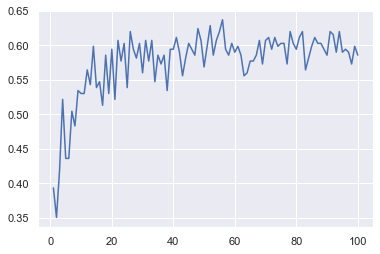

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

X = pd.get_dummies(X)

Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, random_state=0)
Xtrain2, Xval, ytrain2, yval = train_test_split(Xtest, ytest, random_state=0)

accuracies = []
for n in range(100):
    model = RandomForestClassifier(n_estimators=n+1)
    model.fit(Xtrain2, ytrain2)
    ypredval = model.predict(Xval)
    accuracies.append(metrics.accuracy_score(yval, ypredval))

plt.plot(range(1, 101), np.array(accuracies))

In [15]:
model = RandomForestClassifier(n_estimators=60, random_state=0)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

print(metrics.classification_report(ytest, ypred))

              precision    recall  f1-score   support

           a       0.62      0.34      0.44       229
           d       0.40      0.07      0.12       247
           h       0.57      0.95      0.71       460

    accuracy                           0.57       936
   macro avg       0.53      0.45      0.42       936
weighted avg       0.54      0.57      0.49       936



Text(30.5, 0.5, 'Predicted Label')

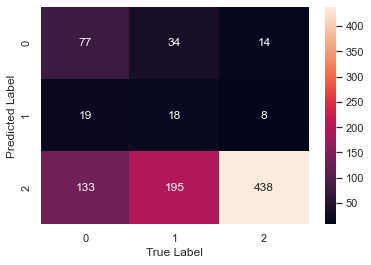

In [17]:
sns.heatmap(metrics.confusion_matrix(ytest, ypred).T, annot=True, fmt='d')
plt.xlabel('True Label')
plt.ylabel('Predicted Label')

## SVM

In [18]:
from sklearn.svm import SVC 
from sklearn.pipeline import make_pipeline

svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(svc)

from sklearn.model_selection import GridSearchCV

param_grid = {'svc__C':[1,5,10,50], 'svc__gamma':[0.0001, 0.0005, 0.001, 0.005]}

grid = GridSearchCV(model, param_grid)

grid.fit(Xtrain, ytrain)
print(grid.best_params_)


{'svc__C': 50, 'svc__gamma': 0.0005}


In [19]:
model = grid.best_estimator_

ypred = model.predict(Xtest)

print(metrics.classification_report(ytest, ypred))

              precision    recall  f1-score   support

           a       0.94      0.94      0.94       229
           d       0.87      0.89      0.88       247
           h       0.96      0.95      0.96       460

    accuracy                           0.93       936
   macro avg       0.93      0.93      0.93       936
weighted avg       0.93      0.93      0.93       936



Text(30.5, 0.5, 'Predicted Label')

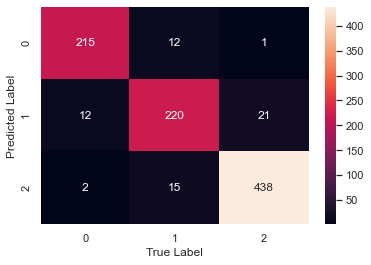

In [20]:
sns.heatmap(metrics.confusion_matrix(ytest, ypred).T, annot=True, fmt='d')
plt.xlabel('True Label')
plt.ylabel('Predicted Label')